# ORCHID Clinical Trial: statistical analysis reproduction

# Version 1.0

This notebook reproduces the statistical analysis of the ORCHID clinical trial. Results have been published to JAMA, on November 7th 2021: ["Effect of Hydroxychloroquine on Clinical Status at 14 Days in Hospitalized Patients With COVID-19"](https://jamanetwork.com/journals/jama/fullarticle/2772922). The statistical analysis plan can be found on [clinicaltrials.gov](https://clinicaltrials.gov/ct2/show/NCT04332991?term=orchid&cond=Covid19&cntry=US&draw=2&rank=1). 

The clinical trial has been conducted between April and July 2020, and stopped before enrollment completion for futility, finding no difference of efficacy between hydroxychloroquine and placebo. This notebook is a reproduction of the clinical trial results based on the clinical trial protocol and the investigators original source code.

## Requirements

*This notebook has been tested to work with R version 4.0.3*. Below is the output of the sessionInfo() function:
```
R version 4.0.3 (2020-10-10)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Catalina 10.15.7

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] stats     graphics  grDevices datasets  utils     methods   base     

other attached packages:
 [1] arsenal_3.5.0     urltools_1.7.3    ggtext_0.1.1      IRdisplay_1.0    
 [5] DescTools_0.99.39 quantreg_5.82     SparseM_1.78      MASS_7.3-53      
 [9] survminer_0.4.8   ggpubr_0.4.0      survival_3.2-7    kableExtra_1.3.1 
[13] devtools_2.3.2    usethis_2.0.0     forcats_0.5.0     stringr_1.4.0    
[17] dplyr_1.0.3       purrr_0.3.4       readr_1.4.0       tidyr_1.1.2      
[21] tibble_3.0.5      ggplot2_3.3.3     tidyverse_1.3.0  

loaded via a namespace (and not attached):
  [1] colorspace_2.0-0   ggsignif_0.6.0     class_7.3-17      
  [4] ellipsis_0.3.1     rio_0.5.16         rprojroot_2.0.2   
  [7] base64enc_0.1-3    fs_1.5.0           gridtext_0.1.4    
 [10] gld_2.6.2          rstudioapi_0.13    MatrixModels_0.4-1
 [13] remotes_2.2.0      hash_2.2.6.1       picsure_0.1.0     
 [16] mvtnorm_1.1-1      fansi_0.4.2        lubridate_1.7.9.2 
 [19] xml2_1.3.2         splines_4.0.3      rootSolve_1.8.2.1 
 [22] knitr_1.30         pkgload_1.1.0      IRkernel_1.1.1    
 [25] jsonlite_1.7.2     broom_0.7.3        km.ci_0.5-2       
 [28] dbplyr_2.0.0       hpds_0.1.0         compiler_4.0.3    
 [31] httr_1.4.2         backports_1.2.1    assertthat_0.2.1  
 [34] Matrix_1.3-2       cli_2.2.0          htmltools_0.5.1   
 [37] prettyunits_1.1.1  tools_4.0.3        lmom_2.8          
 [40] gtable_0.3.0       glue_1.4.2         Rcpp_1.0.6        
 [43] carData_3.0-4      cellranger_1.1.0   vctrs_0.3.6       
 [46] conquer_1.0.2      xfun_0.20          ps_1.5.0          
 [49] openxlsx_4.2.3     testthat_3.0.1     rvest_0.3.6       
 [52] lifecycle_0.2.0    renv_0.12.5        rstatix_0.6.0     
 [55] zoo_1.8-8          scales_1.1.1       hms_1.0.0         
 [58] expm_0.999-6       Exact_2.1          curl_4.3          
 [61] memoise_1.1.0      gridExtra_2.3      KMsurv_0.1-5      
 [64] triebeard_0.3.0    stringi_1.5.3      desc_1.2.0        
 [67] e1071_1.7-4        boot_1.3-25        pkgbuild_1.2.0    
 [70] zip_2.1.1          repr_1.1.3         matrixStats_0.57.0
 [73] rlang_0.4.10       pkgconfig_2.0.3    evaluate_0.14     
 [76] lattice_0.20-41    processx_3.4.5     tidyselect_1.1.0  
 [79] magrittr_2.0.1     R6_2.5.0           generics_0.1.0    
 [82] pbdZMQ_0.3-4       DBI_1.1.1          pillar_1.4.7      
 [85] haven_2.3.1        foreign_0.8-81     withr_2.4.0       
 [88] abind_1.4-5        modelr_0.1.8       crayon_1.3.4      
 [91] car_3.0-10         survMisc_0.5.5     uuid_0.1-4        
 [94] rmarkdown_2.6      grid_4.0.3         readxl_1.3.1      
 [97] data.table_1.13.6  callr_3.5.1        bdc_0.1.0         
[100] reprex_0.3.0       digest_0.6.27      webshot_0.5.2     
[103] xtable_1.8-4       munsell_0.5.0      viridisLite_0.3.0 
[106] sessioninfo_1.1.1 
```

# Data Access using PIC-SURE API

User access authentication works through a security token, which is passed to the API using the token.txt file (file to be created by the user). In order to know how to get your security token, please see [the README of the PIC-SURE API GitHub repo](https://github.com/hms-dbmi/Access-to-Data-using-PIC-SURE-API/tree/master/NHLBI_BioData_Catalyst).

# ORCHID Clinical Trial

It is a multi-center, double blinded, randomized clinical trial conducted to assess the efficacy of hydroxychloroquine in the treatment of COVID-19 in hospitalized patients.

NHLBI made available the data to every authorized investigators. Hence, this notebook enables anybody with authorized credentials to reproduce the ORCHID clinical trial results by showing how to:
1. Access the data using the PIC-SURE API
2. Reproduce the results of this study using the open-source R programming languages

# Overview of the statistical analysis plan

The primary outcome is the COVID-19 Outcome Scale (COS) assess at 14 days. The scale comprises 7 levels, as follows:
- 1, Dead
- 2, Hospitalized on invasive mechanical ventilation or ECMO
- 3, Hospitalized on non-invasive ventilation or high flow nasal cannula
- 4, Hospitalized on supplemental oxygen
- 5, Hospitalized not on supplemental oxygen
- 6, Not hospitalized with limitation in activity (continued symptoms)
- 7, Not hospitalized without limitation in activity (no symptoms)

This scale will also be assessed at different timepoints as secondary outcomes: day-3, day-7, and day-28.

This scale will be treated as an ordered factor, and thus this outcome will be analyzed using a proportional odds regression model. 

Other secondary outcomes will be considered. Death, and composite of death and ECMO will be analyzed using logistic regression models. Time to recovery (patient without oxygen supplementation -- ie COS level 6 or 7) and time to discharge will be analyzed using survival models. Support free-days (hospital, oxygen, ICU, ventilation, and vasopressor) will be treated as ordered factors and analyzed using proportional odds regression models.

All these outcomes will be analyzed using multivariable models, taking into account the following potential confoundings: 
- Age at randomization
- Sex
- Clinical status as assessed by the COVID Ordinal Outcome Scale at randomization
- Sequential Organ Failure Assessment (SOFA) score at randomization
- Duration of acute respiratory infection symptoms prior to randomization

# Packages Installation 

In [2]:
source("R_lib/ORCHID_requirements.R")

Installing package into ‘/Users/Arnaud/git_repos/Access-to-Data-using-PIC-SURE-API/NHLBI_BioData_Catalyst/R/renv/library/R-4.0/x86_64-apple-darwin17.0’
(as ‘lib’ is unspecified)




The downloaded binary packages are in
	/var/folders/hm/wn0bpy0j7vl2q9gqnhhccpph0000gn/T//RtmpDmlgG7/downloaded_packages


── Attaching packages ──────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.5     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ─────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘SparseM’


The following object is masked from ‘package:base’:

    backsolve



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘survival’


The following object is masked from ‘package:quantreg’:

    untangle.specials



Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows


Loading required package: usethis


Attaching package: ‘DescTools’


The following objects are masked from ‘package:arsenal’:

    %nin%, N




In [1]:
options(repr.plot.width=18, repr.plot.height=9)

In [3]:
options(unzip = "internal")
devtools::install_github("hms-dbmi/pic-sure-r-client", force = TRUE)
devtools::install_github("hms-dbmi/pic-sure-r-adapter-hpds", force = TRUE)
devtools::install_github("hms-dbmi/pic-sure-biodatacatalyst-r-adapter-hpds", force = TRUE)


✔  checking for file ‘/private/var/folders/hm/wn0bpy0j7vl2q9gqnhhccpph0000gn/T/RtmpDmlgG7/remotesbd2d31fa62e0/hms-dbmi-pic-sure-r-client-115deb5/DESCRIPTION’ (522ms)
─  preparing ‘picsure’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘picsure_0.1.0.tar.gz’
   


Installing package into ‘/Users/Arnaud/git_repos/Access-to-Data-using-PIC-SURE-API/NHLBI_BioData_Catalyst/R/renv/library/R-4.0/x86_64-apple-darwin17.0’
(as ‘lib’ is unspecified)





✔  checking for file ‘/private/var/folders/hm/wn0bpy0j7vl2q9gqnhhccpph0000gn/T/RtmpDmlgG7/remotesbd2d45b4a67e/hms-dbmi-pic-sure-r-adapter-hpds-2cee5ee/DESCRIPTION’ (391ms)
─  preparing ‘hpds’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘hpds_0.1.1.tar.gz’
   


Installing package into ‘/Users/Arnaud/git_repos/Access-to-Data-using-PIC-SURE-API/NHLBI_BioData_Catalyst/R/renv/library/R-4.0/x86_64-apple-darwin17.0’
(as ‘lib’ is unspecified)





✔  checking for file ‘/private/var/folders/hm/wn0bpy0j7vl2q9gqnhhccpph0000gn/T/RtmpDmlgG7/remotesbd2d75e3f4e0/hms-dbmi-pic-sure-biodatacatalyst-r-adapter-hpds-d019468/DESCRIPTION’ (829ms)
─  preparing ‘bdc’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts (342ms)
─  checking for empty or unneeded directories
─  building ‘bdc_0.1.0.tar.gz’
   


Installing package into ‘/Users/Arnaud/git_repos/Access-to-Data-using-PIC-SURE-API/NHLBI_BioData_Catalyst/R/renv/library/R-4.0/x86_64-apple-darwin17.0’
(as ‘lib’ is unspecified)



# Installing the library and connecting to the database using the PICSURE API 

In [4]:
PICSURE_network_URL <- "https://picsure.biodatacatalyst.nhlbi.nih.gov/picsure"
token_file <- "token.txt"
token <- scan(token_file, what = "character")
# httr::set_config(httr::config(ssl_verifypeer=0L, ssl_verifyhost=0L))
myconnection <- picsure::connect(url = PICSURE_network_URL, token = token)
resource_id <- picsure::list.resources(myconnection)[1]
resource <- bdc::get.resource(myconnection, resourceUUID = resource_id)

[1] "02e23f52-f354-4e8b-992c-d37c8b9ba140"
[2] "70c837be-5ffc-11eb-ae93-0242ac130002"
[1] "Loading data dictionary... (takes a minute)"


# Querying the data

In [5]:
dictionary_results <- bdc::find.in.dictionary(resource, 'ORCHID')
list_variables <- bdc::extract.keys(dictionary_results)
query <- bdc::new.query(resource)
bdc::query.anyof.add(query, list_variables)
raw_df <- bdc::query.run(query, result.type = "dataframe") %>% as_tibble()

# Data Management

The raw data contains long variable names, and the following code trims the uniformative part.

In [6]:
simplified_names <- names(raw_df) %>%
  str_extract('([\\w\\s\\(\\)]+(?=\\\\$))|(Patient\\sID)')
orchid_data <- raw_df[!is.na(simplified_names)]
names(orchid_data) <- simplified_names[!is.na(simplified_names)]
orchid_data <- orchid_data  %>%
  lapply(function(column) {
      if (is.character(column)) {
          as.factor(column) }
      else {
          column
        }
      }
    ) %>%
  as_tibble()

This cell rename signification of the variables that are being used throughout the notebook.

In [8]:
outcomes_labels <- c(
  'safe_seizure' = 'Seizure',
  'safe_vtach' = 'Ventricular tachyarrhythmia',
  'safe_ca' = 'Cardiac arrest treated with CPR',
  'safe_astalt' = 'AST or ALT ≥2 times upper limit of normal',
  'safe_hypogly' = 'Symptomatic hypoglycemia',
  'safe_cytopenia' = 'Cytopenia',
  'd_covid3' = 'COVID Outcomes Scale score at day 2',
  'd_covid8' = 'COVID Outcomes Scale score at day 7',
  'd_covid15' = "COVID Outcomes Scale score at day 14, median (IQR)",
  'd_covid29' = 'COVID Outcomes Scale score at day 28',
  'd_mort15' = 'All-cause, all-location death at Day 14',
  'd_mort29' = 'All-cause, all-location death at Day 28',
  'd_ecmo_death' = 'Composite of death or ECMO through 28 d, No./total No. (%)',
  'd_time_to_recovery' = 'Time to recovery in days, median (IQR)',
  'd_hospfreedays' = 'Hospital-free days',
  'd_icufreedays' = 'ICU-free days',
  'd_oxyfreedays' = 'Oxygen-free days',
  'd_vasofreedays' = 'Vasopressor-free days',
  'd_ventfreedays' = 'Ventilator-free days'
)

table1_labels <- c(
    'bl_sex' = 'Sex',
    'bl_age' = 'Age',
    'race_ethnicity' = 'Ethnicity',
    'bl_prehosp' = 'Location at hospitalization',
    'bmi' = 'BMI' ,
    'diabetes_bool' = 'Diabetes',
    'kidney_bool' = 'Chronic Kidney Disease',
    'cad_bool' = 'Coronary Artery Disease',
    'hypertension_bool' = 'Hypertension',
    'copd_bool' = 'Chronic Obstructive Pulmonary Disease',
    'bl_randloc' = 'Location at randomization',
    'covid_ooscale_1' = 'COVID Clinical Scale at Baseline',
    'vit_vasop_1' = 'Vasopressor',
    'd_sofa_gcs' = 'SOFA at baseline',
    'ie_arisymptoms___cou'= 'Cough',
    'ie_arisymptoms___fev'= 'Fever (temperature >37.5 °C)',
    'ie_arisymptoms___sob'= 'Sobbering',
    'ie_arisymptoms___st'= 'Shortness of breath',
    'd_onset_duration'= 'Symptoms onset duration',
    'labs_wbch_1' = 'Lowest white cells blood count at Day 1(/mm3)',
    'labs_wbcl_1' = 'Highest white cells blood count at Day 1(/mm3)',
    'sofa_platl_1' = 'Lowest platelet count at Day 1(k/mm3)',
    'labs_asth_1' = 'Highest AST - Aspartate aminotransferase (units per liter) (Day 1)'
)
tibble("Variable Name" = names(c(outcomes_labels, table1_labels)), 
      "Meaning" = c(outcomes_labels, table1_labels))

Variable Name,Meaning
<chr>,<chr>
safe_seizure,Seizure
safe_vtach,Ventricular tachyarrhythmia
safe_ca,Cardiac arrest treated with CPR
safe_astalt,AST or ALT ≥2 times upper limit of normal
safe_hypogly,Symptomatic hypoglycemia
safe_cytopenia,Cytopenia
d_covid3,COVID Outcomes Scale score at day 2
d_covid8,COVID Outcomes Scale score at day 7
d_covid15,"COVID Outcomes Scale score at day 14, median (IQR)"


Here we define the group of variables used for the analysis

In [9]:
primary_outcome_name <- "d_covid15"
secondary_outcomes_death <- c("d_mort15",
                               "d_mort29",
                               "d_ecmo_death")
secondary_outcomes_ccs <- c('d_covid3',
                            'd_covid8',
                            'd_covid29')
secondary_outcomes_daysfree <- c(
  'd_time_to_recovery',
  "d_hospfreedays",
  "d_oxyfreedays",
  "d_ventfreedays",
  "d_vasofreedays",
  "d_icufreedays"
)
safety_outcomes <- c(
  'safe_cytopenia',
  'safe_seizure',
  'safe_astalt',
  'safe_hypogly',
  'safe_ca',
  'safe_vtach'
)
chronic_conditions <- c(
    'charl_contis',
    'charl_ulcer',
    'charl_hypertension',
    'charl_cad',
    'charl_fatal',
    'charl_liver',
    'charl_diabetes',
    'charl_kidney',
    'charl_copd'
)
secondary_outcomes_binary <- c(safety_outcomes, secondary_outcomes_death)
ordered_outcome_names <- c(primary_outcome_name, secondary_outcomes_ccs, secondary_outcomes_daysfree)

The code below recode some variables

In [10]:
orchid_data$rand_trt <- relevel(orchid_data$rand_trt, 'Placebo')

# Recoding cytopenia
orchid_data$safe_cytopenia <- apply(
  orchid_data[, c('safe_neutrop',
                  'safe_lympho',
                  'safe_anemia',
                  'safe_thombo')],
  1,
  function(row) ifelse(any(row == 'Yes', na.rm = TRUE), 'Yes', 'No'))

# Recoding respiratory outcomes
respiratory_symptoms_variables <- c(
    'ie_arisymptoms___cou',
    'ie_arisymptoms___fev',
    'ie_arisymptoms___sob',
    'ie_arisymptoms___st'
)
orchid_data[respiratory_symptoms_variables] <- lapply(orchid_data[respiratory_symptoms_variables], 
                                                      function(variable)
                                                      ifelse(variable == "Checked",
                                                             TRUE,
                                                             ifelse(variable == "Unchecked", 
                                                                    FALSE,
                                                                    NA)
                                                            )
                                                      )

dm_factors <- function(factor) {
  factor <- as.character(factor)
  ifelse(factor == '', NA, ifelse(
    factor %in% c('Yes', '1'), 'Yes', ifelse(
      factor %in% c('No', '0'), 'No', NA
    )
  )) %>% as.factor()
}
orchid_data[secondary_outcomes_binary] <- lapply(
  orchid_data[secondary_outcomes_binary],
  dm_factors) %>%
  as_tibble()


create_ordered_daysfree <- function(variable) {
  factor_levels <- as.character(0:28)
  factor_variable <- factor(as.character(variable), ordered = TRUE, levels = factor_levels)
  return(factor_variable)
}
orchid_data[secondary_outcomes_daysfree] <- lapply(
  orchid_data[secondary_outcomes_daysfree], create_ordered_daysfree) %>%
  as_tibble()


# Transforming COVID Clinical scale into ordered factors
create_ordered_covid_clinical_scale <- function(variable) {
  levels <- c(
    '1, Dead',
    '2, Hospitalized on invasive mechanical ventilation or ECMO',
    '3, Hospitalized on non-invasive ventilation or high flow nasal cannula',
    '4, Hospitalized on supplemental oxygen,',
    '5, Hospitalized not on supplemental oxygen',
    '6, Not hospitalized with limitation in activity (continued symptoms)',
    '7, Not hospitalized without limitation in activity (no symptoms)'
  )
  factor(variable, levels = levels, ordered = TRUE)
}
orchid_data[grep('(^d_covid)|(^covid_ooscale)', names(orchid_data))] <- lapply(
  orchid_data[grep('(^d_covid)|(^covid_ooscale)', names(orchid_data))],
  create_ordered_covid_clinical_scale) %>%
  as_tibble()

# Recoding death
orchid_data$vs_died[orchid_data$vs_died == ''] <- NA
orchid_data$vs_died <- fct_recode(orchid_data$vs_died, '0' = 'No', '1' = 'Yes') %>%
  as.character() %>%
  as.numeric()

# Recoding ethnicity
orchid_data$multi_race <- apply(
  orchid_data[c('bl_race___1', 'bl_race___othcat', 'bl_race___5')],
  1, 
  function(row) ifelse(sum(row == 'Checked', na.rm = TRUE) > 1, TRUE, FALSE))
  
orchid_data$race_ethnicity <- 
  ifelse(orchid_data$bl_ethnic == 'Hispanic or Latino',
         'Hispanic or Latino', 
         ifelse(orchid_data$multi_race == TRUE, 
                'Multirace', 
                ifelse(orchid_data$bl_race___1 == 'Checked', 
                       'Black or African American',
                       ifelse(orchid_data$bl_race___5 == 'Checked', 
                              'White', 
                              ifelse(orchid_data$bl_race___othcat == 'Checked', 
                                     'American Indian or Alaska Native/Asian/Native Hawaiian or Other Pacific Islander',
                                     NA)
                       )
                )
         )
  )

# BMI
orchid_data$bmi <- round(orchid_data$bl_weight / (orchid_data$bl_height / 100)^2, 1)

# Chronics comorbidities
orchid_data$diabetes_bool <- ifelse(orchid_data$charl_diabetes %in%
                                      c('DM with end organ damage present (excludes diet controlled alone)',
                                        'Uncomplicated DM present (no end organ damage present)'),
                                    TRUE, FALSE)
orchid_data$kidney_bool <- ifelse(
    orchid_data$charl_kidney %in% c(
    'Moderate to severe kidney disease present (Cr > 3, ESRD, chart diagnosis of CKD stage 5 (eGFR < 15 mL/min/1.73m²) not on dialysis)',
    'Moderate to severe kidney disease present and patient is dialysis dependent'), 
     TRUE, 
     FALSE)
orchid_data$cad_bool <- ifelse(orchid_data$charl_cad == 'Yes', TRUE, FALSE)
orchid_data$hypertension_bool <- ifelse(orchid_data$charl_hypertension == 'Yes', TRUE, FALSE)
orchid_data$copd_bool <- ifelse(orchid_data$charl_copd == 'Yes', TRUE, FALSE)

In [11]:
# Defining the general theme for the plots
orchid_gg_theme <-  function(...) {
  theme_bw() +
  theme(legend.background = element_blank(),
        legend.box.background = element_rect(colour = "black"),
        panel.spacing = grid::unit(c(0), "lines"),
        axis.line = element_line(colour = "black"),
        panel.grid.major = element_blank(),
        text = element_text(size=20),
        plot.title = element_text(size = 20, face = 'bold'),
        axis.text.x = element_text(angle=0, hjust=0.5),
        legend.key.height = unit(.8, "cm"),
        panel.border = element_blank(),
        panel.background = element_blank(),
        strip.background = element_rect(colour = "white", fill = "white")) +
    theme(...)
} 

# Population Description

The following code calculate statistics about baseline characteristics of the population according to treatment groups.

In [17]:
orchid_table1 <- orchid_data
orchid_table1$rand_trt <- relevel(orchid_table1$rand_trt, 'Hydroxychloroquine')

for (label_name in names(table1_labels)) {
    attr(orchid_table1[[label_name]], 'label') <- table1_labels[[label_name]]
}

In [18]:
demographics_table <- tableby(rand_trt ~ 
                             bl_sex +
                             bl_age +
                             race_ethnicity 
                             , data = orchid_table1)

baseline_table <- tableby(rand_trt ~ 
                             bl_randloc +
                             covid_ooscale_1 +
                             vit_vasop_1 
                             , data = orchid_table1)

comorbidity_table <- tableby(rand_trt ~ 
                             diabetes_bool +
                             kidney_bool +
                             cad_bool +
                             hypertension_bool +
                             copd_bool
                             , data = orchid_table1)

symptoms_table <- tableby(rand_trt ~
                          ie_arisymptoms___cou +
                          ie_arisymptoms___fev +
                          ie_arisymptoms___sob +
                          ie_arisymptoms___st,  
                         data = orchid_table1)

admission_table <- tableby(rand_trt ~ d_sofa_gcs + d_onset_duration,
                              data = orchid_table1
)

table1_df <- merge(demographics_table, baseline_table) %>% 
merge(symptoms_table) %>%
merge(admission_table) %>%
merge(comorbidity_table) %>%
as_tibble() %>%
dplyr::select(all_of(c('label', 'Hydroxychloroquine', 'Placebo'))) %>%
rename('Characteristic' = label) %>%
filter(!Characteristic %in% c('FALSE', 'Range'))


In [19]:
table1_df[, c('Hydroxychloroquine', 'Placebo')] <- apply(table1_df[, c('Hydroxychloroquine', 'Placebo')],
       c(1, 2), 
       function(elem) {
           elem_bis <- unlist(elem)
           ifelse(elem != '', 
                  unlist(elem_bis) %>%
                  round(1) %>%
                  paste0(collapse = ' (') %>%
                  paste0(')'),
                  elem_bis
                  )
     }
) %>% as_tibble()

In [20]:
indices_cat <- which(table1_df['Hydroxychloroquine'] == '')
indices_results <- which(table1_df['Hydroxychloroquine'] != '')

kbl(table1_df, caption = "Table 1: Description of the population") %>%
kable_minimal() %>% kable_styling(bootstrap_options = c("striped"), 
                                  full_width = FALSE,
                                  position = "left", 
                                 font_size = 12) %>%
  column_spec(1, width = "20em") %>%
  column_spec(2, width = "10em") %>% 
  column_spec(3, width = "10em") %>% 
add_header_above(c(" ", "No. (%)" = 2), align = 'left') %>%
row_spec(0, bold = TRUE, extra_css = "font-size: medium") %>%
row_spec(indices_cat, underline = FALSE, bold = TRUE, align = 'left') %>%
column_spec(1, background = 'FDEBD0') %>%
kableExtra:::add_indent_html(positions = indices_results) %>%
pack_rows('Demographics', 1, 20, indent = FALSE, label_row_css = "text-align: left; font-style: italic") %>%
pack_rows('COVID-19 Symptoms', 20, 42, indent = FALSE, label_row_css = "text-align: left; font-style: italic") %>%
pack_rows('Comorbidities', 43, 52, indent = FALSE, label_row_css = "text-align: left; font-style: italic") %>%
as.character() %>%
str_replace_all(c("Comorbidities"),
            replacement = function(string) paste0(string, '<hr>')) %>%
str_replace_all(c("Demographics"),
            replacement = function(string) paste0(string, '<hr>')) %>%
str_replace_all(c("COVID-19 Symptoms"),
            replacement = function(string) paste0(string, '<hr>')) %>%
display_html()

Table 1: Description of the population 
 
 
 
 No. (%) 
 
 
 Characteristic 
 Hydroxychloroquine 
 Placebo 
 
 
 
 Demographics 
 
 Sex 
 
 
 
 
 Female 
 106 (43.8) 
 105 (44.3) 
 
 
 Male 
 135 (55.8) 
 132 (55.7) 
 
 
 Other/Unknown 
 1 (0.4) 
 0 (0) 
 
 
 Age 
 
 
 
 
 Mean (SD) 
 57.6 (15.9) 
 56.1 (17) 
 
 
 Ethnicity 
 
 
 
 
 N-Miss 
 10) 
 10) 
 
 
 American Indian or Alaska Native/Asian/Native Hawaiian or Other Pacific Islander 
 11 (4.7) 
 19 (8.4) 
 
 
 Black or African American 
 57 (24.6) 
 55 (24.2) 
 
 
 Hispanic or Latino 
 91 (39.2) 
 87 (38.3) 
 
 
 Multirace 
 1 (0.4) 
 1 (0.4) 
 
 
 White 
 72 (31) 
 65 (28.6) 
 
 
 Location at randomization 
 
 
 
 
 emergency department 
 34 (14) 
 38 (16) 
 
 
 hospital ward 
 157 (64.9) 
 132 (55.7) 
 
 
 intensive care unit 
 37 (15.3) 
 54 (22.8) 
 
 
 other 
 0 (0) 
 1 (0.4) 
 
 
 step-down unit or intermediate care unit 
 14 (5.8) 
 12 (5.1) 
 
 COVID-19 Symptoms 
 
 COVID Clinical Scale at Baseline 
 
 
 
 
 1, Dead 
 0 (0) 
 0 (0) 
 
 
 2, Hospitalized on invasive mechanical ventilation or ECMO 
 13 (5.4) 
 19 (8) 
 
 
 3, Hospitalized on non-invasive ventilation or high flow nasal cannula 
 28 (11.6) 
 27 (11.4) 
 
 
 4, Hospitalized on supplemental oxygen, 
 116 (47.9) 
 108 (45.6) 
 
 
 5, Hospitalized not on supplemental oxygen 
 85 (35.1) 
 83 (35) 
 
 
 6, Not hospitalized with limitation in activity (continued symptoms) 
 0 (0) 
 0 (0) 
 
 
 7, Not hospitalized without limitation in activity (no symptoms) 
 0 (0) 
 0 (0) 
 
 
 Vasopressor 
 
 
 
 
 No 
 234 (96.7) 
 217 (91.6) 
 
 
 Yes 
 8 (3.3) 
 20 (8.4) 
 
 
 Cough 
 
 
 
 
 TRUE 
 143 (59.1) 
 140 (59.1) 
 
 
 Fever (temperature >37.5 °C) 
 
 
 
 
 TRUE 
 138 (57) 
 132 (55.7) 
 
 
 Sobbering 
 
 
 
 
 TRUE 
 175 (72.3) 
 168 (70.9) 
 
 
 Shortness of breath 
 
 
 
 
 TRUE 
 21 (8.7) 
 14 (5.9) 
 
 
 SOFA at baseline 
 
 
 
 
 Mean (SD) 
 2.8 (2.9) 
 3.1 (3.6) 
 
 
 Symptoms onset duration 
 
 
 
 
 Mean (SD) 
 5.2 (2.8) 
 5.2 (2.8) 
 
 Comorbidities 
 
 Diabetes 
 
 
 
 
 TRUE 
 88 (36.4) 
 78 (32.9) 
 
 
 Chronic Kidney Disease 
 
 
 
 
 TRUE 
 28 (11.6) 
 14 (5.9) 
 
 
 Coronary Artery Disease 
 
 
 
 
 TRUE 
 19 (7.9) 
 23 (9.7) 
 
 
 Hypertension 
 
 
 
 
 TRUE 
 136 (56.2) 
 117 (49.4) 
 
 
 Chronic Obstructive Pulmonary Disease 
 
 
 
 
 TRUE 
 18 (7.4) 
 21 (8.9)

# Outcome Analysis

## Primary Outcome: COVID-19 Ordinal Outcome Scale at Day 14

Primary outcome evolution: evolution of the COVID-19 Ordinal Outcome Scale between day 0 and day 14.

In [21]:
covid_ooscale_renaming <- c(
    "1, Dead" = "1: Death",
    "2, Hospitalized on invasive mechanical ventilation or ECMO" = "2: Invasive mechanical ventilation or ECMO",
    "3, Hospitalized on non-invasive ventilation or high flow nasal cannula" = "3: Non-invasive ventilation or high flow nasal cannula",
    "4, Hospitalized on supplemental oxygen," = "4: Hospitalized with oxygen",
    "5, Hospitalized not on supplemental oxygen" = "5: Hospitalized without oxygen",
    "6, Not hospitalized with limitation in activity (continued symptoms)" = "6: Discharged, limitation in activity",
    "7, Not hospitalized without limitation in activity (no symptoms)" = "7: Discharged, no limitation in activity"
)

In [ ]:
coos_df <- orchid_data %>%
  dplyr::select(subject_id, rand_trt, starts_with("d_covid")) %>%
  pivot_longer(cols = starts_with("d_covid"),
               names_to = "date",
               values_to = "COOS") %>%
  mutate(COOS =  fct_rev(COOS)) %>%
  mutate(COOS = recode(COOS, !!!covid_ooscale_renaming))


plot_count_COOS <- coos_df %>%
  filter(date %in% c("d_covid15", "d_covid29")) %>%
  mutate(rand_trt = fct_recode(relevel(rand_trt, 'Hydroxychloroquine'),
                               "Hydroxychloroquine\n(n=242)" = "Hydroxychloroquine",
                               "Placebo\n(n=237)" = "Placebo"),
         date = fct_recode(date,
                           "14 d After randomization\n(primary outcome)" = "d_covid15",
                           "28 d After randomization\n(secondary outcome)" = "d_covid29")) %>%
  ggplot() +
  geom_bar(aes(x = rand_trt, fill = COOS), 
           width = 0.4, position="fill", colour = "black") +
  scale_y_continuous(labels = scales::percent,
                     n.breaks = 6,
                     limits = c(0, 1)) +
  facet_grid( ~ date) +
  scale_fill_brewer(palette = "Blues") +
  orchid_gg_theme(plot.title = element_markdown()) +
  labs(title="Clinical Status on the Coronavirus Disease (COVID) Outcomes Scale 14 Days and 28 Days After Randomization",
       fill = "Clinical status (COVID Outcomes Scale category)"
       ) +
  xlab("Treatment group") +
  ylab("Patients with clinical status, %")

plot_data <- ggplot_build(plot_count_COOS)$data
line_data <- plot_data[[1]] %>%
    mutate(x_line = if_else(x == 1, xmax, xmin), 
           date = as.factor(if_else(PANEL == 1, 
                           "14 d After randomization\n(primary outcome)",
                           "28 d After randomization\n(secondary outcome)"
                            ))
          )
         
plot_count_COOS <- plot_count_COOS + 
    geom_line(data = line_data,
              aes(x = x_line, y = ymax, group = fill), 
              linetype = "dashed"
              )
print(plot_count_COOS)

## Primary and secondary outcomes comparison

Below we define a group of functions to analyze the outcomes

In [ ]:
# Functions defined in this cell are being used to analysis the variables formatted as ordered factors
fitted_polr <- function(outcome, covariates, data) {
  formula <- paste(outcome,
                   paste(covariates, collapse = " + "),
                   sep = " ~ ")
  fitted_model <- MASS::polr(formula, Hess = TRUE, dat = data)
  return(fitted_model)
}

dm_polr_results <- function(fitted_model) {
  coef_table <- coef(summary(fitted_model))['rand_trtHydroxychloroquine',]
  OR <- exp(coef(fitted_model))['rand_trtHydroxychloroquine']
  coeff_names <- names(OR)
  ci <- exp(coef_table['Value'] + qnorm(c(0.025, 0.975))*coef_table['Std. Error'])
  p <- pnorm(abs(coef_table["t value"]), lower.tail = FALSE) * 2
  result_model_polyr <- round(c(OR, ci, p), 2)
  names(result_model_polyr) <- c('OR', '2.5%', '97.5%', 'pvalue')
  df_results = as.data.frame(result_model_polyr)
  df_results[['attribute']] = row.names(df_results)
  df_results[['entity']] = 'adjusted'
  df_results[['group']] = 'all'
  df_results[['outcome_type']] = 'Outcomes'
  df_results[['string']] = paste0(result_model_polyr['OR'],
                                  ' (',
                                  result_model_polyr['2.5%'],
                                  ' to ', 
                                  result_model_polyr['97.5%'],
                                  ')'
                                  )
  names(df_results)[names(df_results) == 'result_model_polyr'] = 'value'
  return(df_results)
}


ordered_factor_to_numeric <- function(column) {
  col <- as.character(column)
  matching <- regexpr('^[0-9]+', col)
  as.numeric(
      ifelse(matching != -1, 
            regmatches(col, matching), 
            col)
  )
}


ordered_factors_analysis <- function(ordered_outcome_names, covariates, data) {        
    list_results_outcomes <- list()
    for (outcome_name in ordered_outcome_names) {
      fitted_model <- fitted_polr(outcome_name, covariates, data)
      df_results_polyr <- dm_polr_results(fitted_model)
      df_quartiles <<- get_quartiles(outcome_name, 'rand_trt', data)
      difference <<- df_quartiles[df_quartiles$attribute == '50%' &
                                df_quartiles$group == 'Hydroxychloroquine', 
                                'value'] - 
      df_quartiles[df_quartiles$attribute == '50%' &
                                df_quartiles$group == 'Placebo', 
                                'value']
      df_differences <- ci_quantreg(outcome = outcome_name,
                                    group = 'rand_trt',
                                    difference = difference, 
                                    df = data)
      col_order = c('group', 'entity', 'attribute', 'value', 'outcome_type', "string")
      df_result_outcome <- list(df_results_polyr, df_quartiles, df_differences) %>% 
        lapply(function(df) df[col_order]) %>%
        do.call(rbind, args = .)
      row.names(df_result_outcome) <- NULL
      list_results_outcomes[[outcome_name]] <- df_result_outcome
    }
  return(list_results_outcomes)
}

In [ ]:
# Functions to analyze continuous outcomes
get_quartiles <- function(outcome, group, data) {
  trt_group <- relevel(data[[group]], 'Hydroxychloroquine')
  numeric_var <- ordered_factor_to_numeric(data[[outcome]])
  df_quartiles <- tapply(numeric_var,
         list(trt_group),
         FUN = function(var) {
      trunc(quantile(var, probs = c(0.25, 0.5, 0.75), na.rm = TRUE))          
    }
  ) %>%
    do.call(data.frame, args = .) %>%
    t() %>%
    as.data.frame()
  df_quartiles["string"] = paste0(df_quartiles[["50%"]], " (", df_quartiles[["25%"]], "-", df_quartiles[["75%"]], ")")
  df_quartiles[['entity']] = 'count'
  df_quartiles[['group']] = row.names(df_quartiles)
  df_results <- pivot_longer(df_quartiles,
               cols = c("25%", "50%", "75%"), 
               names_to = 'attribute', 
              values_to = 'value') %>%
    mutate(outcome_type = 'Outcomes')
 
}

ci_quantreg <- function(outcome, group, difference, df) {
  numeric_var <- ordered_factor_to_numeric(df[[outcome]])
  non_nan <- !is.na(numeric_var)
  qr_b <- boot.rq(cbind(1, df[[group]][non_nan]), numeric_var[non_nan], tau = 0.5, R = 10000)
  ci <- t(apply(qr_b$B, 2, quantile, c(0.025,0.975)))[2, ]
  df_results <- data.frame('value' = ci)
  df_results[['entity']] = 'unadjusted'
  df_results[['attribute']] = row.names(df_results)
  df_results[['group']] = 'all'
  df_results[['outcome_type']] = 'Outcomes'
  df_results[['string']] = paste0(difference, ' (', ci[['2.5%']], ' to ',  ci[['97.5%']], ')')
  return(df_results)
}

In [ ]:
# Functions to analyze binary outcomes
fitted_logisticr <- function(outcome, covariates, data) {
    model <- as.formula(paste0(outcome, '~', paste(covariates, collapse = '+')))
    glm(model, data = orchid_data, family = binomial(link='logit'))
}
           
dm_result_logistr <- function(fitted_model, outcome) {
  coef_table <- coef(summary(fitted_model))['rand_trtHydroxychloroquine',]
  OR <- exp(coef(fitted_model))['rand_trtHydroxychloroquine']
  ci <- exp(coef_table['Estimate'] + qnorm(c(0.025, 0.975))*coef_table['Std. Error'])
  results <- round(c(OR, ci), 2)
  df_results = data.frame('value' = results)
  df_results[['attribute']] = c('OR', '2.5%', '97.5%')
  if (any(is.infinite(ci))) df_results[['value']] <- NA 
  df_results[['entity']] = 'adjusted'
  df_results[['group']] = 'all'
  df_results[['outcome_type']] = if (outcome %in% safety_outcomes) 'Safety Outcomes' else 'Outcomes'
  df_results[['string']] = paste0(df_results[df_results$attribute == "OR", "value"],
                                    " (", 
                                    df_results[df_results$attribute == "2.5%", 'value'],
                                    " - ",
                                    df_results[df_results$attribute == "97.5%", 'value'], 
                                   ")")
  return(df_results)
}

get_table_count <- function(data, binary_outcome, safety_outcomes) {
 non_na <- ! (is.na(data[[binary_outcome]]) | data[[binary_outcome]] == '')
 table_count <- table(data[non_na, c('rand_trt', binary_outcome)]) %>%
   as.data.frame() %>%
   pivot_wider(names_from = all_of(binary_outcome), values_from = 'Freq') %>%
   mutate(freq = round(Yes/(Yes + No), 3) * 100) %>%
   pivot_longer(cols = c('No', 'Yes', 'freq'), 
               names_to = 'attribute') %>%
   mutate(entity = 'count') %>%
   rename(group = rand_trt)
   table_count[['outcome_type']] = if (binary_outcome %in% safety_outcomes) 'Safety Outcomes' else 'Outcomes'
   values <- table_count[["value"]]             
   names(values) = table_count[["attribute"]]               
   string = tapply(values, table_count$group,
          function(vector) paste0(vector[["Yes"]], 
                                  " (",
                                  round(vector[["Yes"]]*100/(vector[["Yes"]] + vector[["No"]]), 1), 
                                  ")")
                             )
   df_string = string %>% data.frame()
   names(df_string) = c("string")
   df_string[["group"]] = row.names(df_string)
   inner_join(table_count, df_string, by = "group")         
}

In [ ]:
## Binary outcomes : binomial CI + logistic regression
binary_outcomes_analysis <- function(binary_outcomes,
                                     covariates, 
                                     data) {
    list_results_outcomes <- list()
    for (binary_outcome in binary_outcomes) {
      if (binary_outcome %in% secondary_outcomes_death) {
          model_covariates = covariates
      } else {
          model_covariates = 'rand_trt'
      }
      fitted_model <- fitted_logisticr(outcome = binary_outcome, 
                                        covariates = model_covariates, 
                                        data = data)
      df_logistr <- dm_result_logistr(fitted_model, binary_outcome)
        

     table_count <- get_table_count(data, binary_outcome, safety_outcomes)

      df_differences <- BinomDiffCI(
          x1 = as.numeric(
              table_count[table_count$group == 'Placebo' & 
                          table_count$attribute == 'Yes',
                          'value']
              ), 
          n1 = sum(table_count[table_count$group == 'Placebo' & 
                                       table_count$attribute %in% c('Yes', 'No'),
                                        'value'] ),
          x2 = as.numeric(table_count[table_count$group == 'Hydroxychloroquine' & 
                                       table_count$attribute == 'Yes',
                                        'value']),
          n2 = sum(table_count[table_count$group == 'Hydroxychloroquine' & 
                                       table_count$attribute %in% c('Yes', 'No'),
                                        'value'] ),
                  method = "wald") %>%
        round(3) %>%
        `*`(100) %>% 
        t() %>%
        data.frame(value = .)
      df_differences[["string"]] = paste0(df_differences["est", "value"], 
       " (", 
       df_differences["lwr.ci", "value"], 
       " to ", 
       df_differences["upr.ci", "value"],
       ")")

      df_differences[['entity']] = 'unadjusted'
      df_differences[['attribute']] = row.names(df_differences)
      df_differences[['group']] = 'all'  
      df_differences[['outcome_type']] = if (binary_outcome %in% safety_outcomes) 'Safety Outcomes' else 'Outcomes'
      col_order = c('group', 'entity', 'attribute', 'value', 'outcome_type', "string")
      df_result_outcome <- list(df_logistr, table_count, df_differences) %>% 
        lapply(function(df) df[col_order]) %>%
        do.call(rbind, args = .)
      row.names(df_result_outcome) <- NULL
      list_results_outcomes[[binary_outcome]] <- df_result_outcome
    }
  return(list_results_outcomes)
}

In [ ]:
data_manage_results <- function(list_results_ordered, list_results_binary) {
    outcome_comparison <- do.call(rbind, c(list_results_ordered, list_results_binary, deparse.level = 0))
    outcome_comparison[['outcome']] <- gsub('\\.[0-9]+$', '', row.names(outcome_comparison))
    row.names(outcome_comparison) <- NULL
    outcome_comparison$outcome_type <- factor(outcome_comparison$outcome_type,
                                              levels = c('Outcomes', 'Safety Outcomes'))
    outcome_comparison$outcome <- factor(outcome_comparison$outcome, 
                                         levels = c(safety_outcomes, 
                                                    secondary_outcomes_daysfree, 
                                                    secondary_outcomes_death, 
                                                    secondary_outcomes_ccs, 
                                                    primary_outcome_name)
                                         )
    return(outcome_comparison)
}

data_manage_table <- function(outcome_comparison) {
    outcome_models <- outcome_comparison[c("string", "outcome", "entity")] %>%
    filter(entity %in% c("unadjusted", "adjusted")) %>%
    unique() %>%
    pivot_wider(names_from = "entity", values_from = "string")
    outcome_counts <- outcome_comparison[c("string", "outcome", "group", "entity")] %>%
    filter(entity %in% c("count")) %>%
    unique() %>%
    pivot_wider(names_from = "group", values_from = "string")
    table_results_outcomes <- inner_join(outcome_models, outcome_counts, by = "outcome") %>%
      as.data.frame()
    row.names(table_results_outcomes) <- outcomes_labels[as.character(table_results_outcomes$outcome)]
    table_results_outcomes <- table_results_outcomes[!names(table_results_outcomes) %in% c("outcome", "entity")]
    
    list_renaming_columns <- c(    
        "Hydroxychloroquine" = "Hydroxychloroquine (n = 242)",
        "Placebo" = "Placebo (n = 237)",
        "unadjusted" = "Unadjusted absolute difference (95% CI)",
        "adjusted" = "Adjusted odds ratio or odds ratio (95% CI)"
    )
    table_results_outcomes <- table_results_outcomes[names(list_renaming_columns)]
    names(table_results_outcomes) <- list_renaming_columns[names(table_results_outcomes)]
    return(table_results_outcomes)
}

## Outcomes Analyses

The outcomes will be analyzed in univariate and multivariate analyses. The multivariable model adjust the treatment effect on 5 confoundings: 
- Age at baseline
- Gender
- COVID clinical scale evaluated at baseline (treated as a covariate with 3 levels: 1. invasive or non-invasive ventilation, 2. oxygen supplementation, and 3. no oxygen supplementation)
- SOFA score at baseline
- Time between inclusion and symptoms onset

In [ ]:
# Creation of dummy variables based on the COVID clinical scale at inclusion 
oo_scale1_l3 <- ifelse(as.numeric(orchid_data$covid_ooscale_1) == 3, 
                      TRUE, 
                      FALSE)
oo_scale1_l4 <- ifelse(as.numeric(orchid_data$covid_ooscale_1) == 4, 
                      TRUE, 
                      FALSE)
oo_scale1_l5 <- ifelse(as.numeric(orchid_data$covid_ooscale_1) == 5, 
                      TRUE, 
                      FALSE)

orchid_data$sex_dm <- ifelse(
    orchid_data$bl_sex == "Other/Unknown", 
    NA,
    orchid_data$bl_sex
)

# Set of variables included in the adjusted model
covariates <- c('rand_trt',
                'bl_age',
                'sex_dm',
                'd_sofa_gcs',
                'bl_symptomdt', 
                "oo_scale1_l3",
                "oo_scale1_l4",
                "oo_scale1_l5")

In [ ]:
list_results_ordered <- ordered_factors_analysis(ordered_outcome_names, 
                                                 covariates = covariates, 
                                                 data = orchid_data)

list_results_binary <- binary_outcomes_analysis(c(secondary_outcomes_death, safety_outcomes), 
                                                covariates,
                                                orchid_data)

In [ ]:
outcome_comparison <- data_manage_results(list_results_ordered, list_results_binary)
table_results_outcomes <- data_manage_table(outcome_comparison)

In [ ]:
table_results <- table_results_outcomes %>%
  kable(caption="Effect of Hydroxychloroquine on COVID Outcomes Scale") %>%
  kable_minimal() %>%
  pack_rows('Primary Outcome', 1, 1, indent = FALSE, label_row_css = "text-align: left; font-style: italic") %>%
  pack_rows('Secondary Outcomes', 2, 2, indent = FALSE, label_row_css = "text-align: left; font-style: italic") %>%
  pack_rows('COVID Outcomes Scale score, median (IQR)', 2, 4, indent = TRUE, label_row_css = "text-align: left") %>%
  pack_rows('Support-free days through day 28, median (IQR)', 6, 10, indent = TRUE, label_row_css = "text-align: left") %>%
  pack_rows('All-cause, all-location death, No. (%)', 11, 12, indent = TRUE, label_row_css = "text-align: left") %>%
  pack_rows('Systematically collected safety events, No. (%)', 14, 19, indent = FALSE, label_row_css = "text-align: left; font-style: italic") %>%
  as.character() %>%
str_replace_all(c("Primary Outcome"),
            replacement = function(string) paste0(string, '<hr>')) %>%
str_replace_all(c("Secondary Outcomes"),
            replacement = function(string) paste0(string, '<hr>')) %>%
str_replace_all(c("Systematically collected safety events, No\\. \\(\\%\\)"),
            replacement = function(string) paste0(string, '<hr>')) %>%
str_replace("Placebo \\(n = 237\\)",
            replacement = "Placebo <br>(n = 237)") %>%
str_replace("Hydroxychloroquine \\(n = 242\\)",
            replacement = "Hydroxychloroquine <br>(n = 242)") %>%
str_replace("COVID Outcomes Scale score, median \\(IQR\\) at Day 14",
            replacement = "<b>Outcomes Scale score, median (IQR) at Day 14</b>") %>%
  as.character() %>%
  IRdisplay::display_html()  

In [ ]:
forest_plot <- function(table_results_outcomes, outcomes_labels) {
  outcomes_labels["d_covid15"] <- "**COVID Outcomes Scale score, median (IQR) at Day 14**"
  plt <- table_results_outcomes[table_results_outcomes$entity == 'adjusted' & 
                          ! is.na(table_results_outcomes$value), ] %>%
  pivot_wider(names_from = attribute, values_from = value) %>%
ggplot(aes(x = outcome, y = OR, ymin = `2.5%`, ymax = `97.5%`)) + 
  geom_pointrange() + 
  coord_flip() + 
  facet_grid(outcome_type ~ . ,
             scales = 'free', 
            space = 'free', 
            switch = 'y') +
  geom_hline(yintercept = 1) +
  scale_x_discrete(labels=outcomes_labels) +
  # scale_y_continuous(labels=c(0, 1, 2, 4, 6, 8)) +
  orchid_gg_theme(panel.spacing = unit(2, "lines"), 
                 axis.text.y = element_markdown()) + 
  labs(title = 'Hydroxychloroquine adjusted effects on the outcomes', 
      x = '', 
      y = 'Odds Ratio')
  return(plt)
}

In [ ]:
suppressWarnings(print(forest_plot(outcome_comparison, outcomes_labels)))

## Survival Outcomes

## All-cause survival

Survival has been analyzed through a Kaplan-Meïer curve, and difference in the survival curved tested using a log-rank test. Adjusted treatment effect on all-cause death was estimated using an adjusted hazard regression model.

In [ ]:
CENSOR_TIME <- 28

In [ ]:
orchid_data$death_within_28 <- ifelse(
    orchid_data$vs_deathdt <= 28,
    1, 
    0
) %>% replace_na(0)

orchid_data$death_fu <- orchid_data$d_lastalivedt + 1
no_fu_individuals <- apply(orchid_data[c('vs_alivedt', 'vs_deathdt')],
                                      1,
                                      function(x) sum(is.na(x)) == 2)

survival_data <- orchid_data[!no_fu_individuals, ]

survival_data$fu_death_28 <- pmin(28, 
                            survival_data$vs_alivedt,
                            survival_data$vs_deathdt,
                           na.rm = TRUE)

coxph_death <- coxph(Surv(time = survival_data$fu_death_28,
                          event = survival_data$death_within_28) ~
                       rand_trt + bl_age + bl_sex + covid_ooscale_1 + d_sofa_gcs_s + bl_symptomdt,
                     data = survival_data)


survfit_death <- survfit(Surv(time = survival_data$fu_death_28,
                              event = survival_data$death_within_28) ~ rand_trt,
                         data = survival_data)

In [ ]:
death_plot <- ggsurvplot(survfit_death,
           xlim = c(1, 28),
           size = 1.3,                 
           palette = c("#275057", "#F4890B"),
           conf.int = FALSE,          
           pval = TRUE,              
           risk.table = FALSE,        
           risk.table.col = "strata",
           legend.labs =c("Placebo", "Hydroxychloroquine"),
           risk.table.height = 0.25,
           ggtheme = theme_bw() +  theme(
        text = element_text(size=20),
        axis.text.x = element_text(angle=0, hjust=0.5)),
           combine = TRUE,
           keep_data = TRUE,
           type="cuminc",
           title = "Survival Through 28 Days Following Randomization",
)

death_plot

### Hospital discharge 

Time to hospital-discharge between treatment groups has been analyzed using a Fin and Gray Model, treating death as a competing risk. A patient was considered discharge at first hospital discharge, regardless of eventual rehospitalization or death occuring afterwards.

Adjusted treatment effect on time to hospital-discharge was estimated using an adjusted hazard regression model.

In [ ]:
discharge_data <- orchid_data

discharge_data$discharge_status <- with(discharge_data, 
                        ifelse(!is.na(vs_deathdt) & !is.na(iho_dischdt), 
                               ifelse(vs_deathdt <= iho_dischdt, 
                                      "dead",
                                      "discharged"),
                               ifelse(!is.na(vs_deathdt),
                                      "dead",
                                      ifelse(!is.na(iho_dischdt),
                                             "discharged",
                                             "censored")
                                     )
                               )
) %>% factor(levels = c("censored", "discharged", "dead"))
discharge_data$discharge_dt <- with(discharge_data, 
                                    ifelse(                                        
                                        discharge_status == "discharged", 
                                        iho_dischdt, 
                                        ifelse(discharge_status == "dead", 
                                              vs_deathdt, 
                                              ifelse(discharge_status == "censored", 
                                                    vs_alivedt, 
                                                    NA)
                                              )
                                        )
                                    ) %>%
ifelse(. <= CENSOR_TIME, ., CENSOR_TIME)

In [ ]:
discharge_fit <- cmprsk::cuminc(
    ftime = discharge_data$discharge_dt, 
    fstatus = as.numeric(discharge_data$discharge_status), 
    cencode = 1, 
    group = as.numeric(discharge_data$rand_trt)
)
pvalue_gray <- round(discharge_fit[["Tests"]][1, "pv"], 2)

In [ ]:
survfit_discharge <- survfit(Surv(
    discharge_data$discharge_dt, 
    ifelse(discharge_data$discharge_status == "discharged", 1, 0), 
    ) ~ rand_trt, 
    data = discharge_data[c("discharge_dt", "discharge_status", "rand_trt")]
                            )

ggsurvplot(
  survfit_discharge, 
  xlim = c(1, 28),
  size = 1.3,
  risk.table = FALSE,        
  palette = c("#F4890B", "#275057"),
  conf.int = FALSE,          
  pval = pvalue_gray,              
  risk.table.col = "strata",
  legend.labs = c("Hydroxychloroquine", "Placebo"),
  risk.table.height = 0.25,
  ggtheme = theme_bw() +  theme(
  text = element_text(size=20),
  axis.text.x = element_text(angle=0, hjust=0.5)),
  combine = TRUE,
  keep_data = TRUE,
  linetype = 'strata',
  fun = 'event',
  type = "cuminc",
  title = "Hospital Discharge Through 28 Days Following Randomization"
)

# Sensitivity Analyses

This notebook can also be useful to kickstart new analyses. The heavy lifting data management has already been done and allows the user to expand quickly the original work. As an example, we are going to focus on the lab trajectories in the different treatment groups, and how it is related to the use of premedication by azithromycin.

## Time to recovery associated with premedications

In [22]:
premedications <- c(
        "prmed_chlor",
        "prmed_hydroxychlor",
        "prmed_remdesivir",
        "prmed_lopinavir",
        "prmed_corticoster",
        "prmed_tocilizumab",
        "prmed_sarilumab",
        "prmed_interferon",
        "prmed_azithro"
    )

In [23]:
coos_df <- orchid_data %>%
  dplyr::select(subject_id, covid_ooscale_1, prmed_azithro, starts_with("d_covid")) %>%
  pivot_longer(cols = c(starts_with("d_covid"), covid_ooscale_1),
               names_to = "date",
               values_to = "COOS") %>%
  mutate(COOS =  fct_rev(COOS)) %>%
  mutate(COOS = recode(COOS, !!!covid_ooscale_renaming))

In [41]:
table_outcomes_count <- coos_df %>%
  filter(date %in% c("covid_ooscale_1", "d_covid15", "d_covid29")) %>%
  mutate(prmed_azithro = as.factor(prmed_azithro)) %>%
  mutate(prmed_azithro = fct_recode(relevel(prmed_azithro, 'Yes'),
                               "Yes\n(n=150)" = "Yes",
                               "No\n(n=329)" = "No"),
         date = fct_recode(date,
                           "At randomization" = "covid_ooscale_1", 
                           "14 d After randomization\n(primary outcome)" = "d_covid15",
                           "28 d After randomization\n(secondary outcome)" = "d_covid29"))
 

In [109]:
table_count_azithro <- table_outcomes_count %>%
  group_by(prmed_azithro, COOS, date) %>%
  summarize(count = n()) %>%
  group_by(prmed_azithro, date) %>%
  mutate(percentage = round(count/sum(count) * 100, 1)) %>%
  mutate(string = glue::glue("{count} ({percentage}%)", count = count, percentage = percentage)) %>% 
  pivot_wider(id_cols = c(COOS),
              names_from = c(date, prmed_azithro), 
              values_from = string) %>%
  arrange(desc(COOS)) %>%
  mutate(across(everything(), replace_na, "0 (0%)")) %>%
  `[`(c(1, 4, 7, 2, 5, 3, 6))

`summarise()` has grouped output by 'prmed_azithro', 'COOS'. You can override using the `.groups` argument.

Warning message in `[<-.factor`(`*tmp*`, !is_complete(data), value = "0 (0%)"):
“invalid factor level, NA generated”


In [110]:
names(table_count_azithro) <-  c("COOS", 
         "Yes (n=150)",
         "No (n=329)",
         "Yes (n=150)",
         "No (n=329)",
         "Yes (n=150)",
         "No (n=329)")
table_count_azithro %>%
kbl() %>%
kable_minimal() %>% 
kable_styling(bootstrap_options = c("striped"), 
                                full_width = FALSE,
                                 position = "left", 
                                 font_size = 12) %>%
  column_spec(1, width = "20em") %>%
  column_spec(2, width = "10em") %>% 
  column_spec(3, width = "10em") %>% 
add_header_above(c(" " = 1, "At randomization" = 2, 
                  "14 d After randomization" = 2, 
                  "28 d After randomization" = 2),
                 align = 'left') %>%
as.character() %>%
display_html()

At randomization 
 14 d After randomization 
 28 d After randomization 
 
 
 COOS 
 Yes (n=150) 
 No (n=329) 
 Yes (n=150) 
 No (n=329) 
 Yes (n=150) 
 No (n=329) 
 
 
 
 
 1: Death 
 0 (0%) 
 0 (0%) 
 10 (6.7%) 
 22 (6.7%) 
 17 (11.3%) 
 33 (10%) 
 
 
 2: Invasive mechanical ventilation or ECMO 
 16 (10.7%) 
 16 (4.9%) 
 20 (13.3%) 
 22 (6.7%) 
 12 (8%) 
 11 (3.3%) 
 
 
 3: Non-invasive ventilation or high flow nasal cannula 
 22 (14.7%) 
 33 (10%) 
 3 (2%) 
 9 (2.7%) 
 0 (0%) 
 0 (0%) 
 
 
 4: Hospitalized with oxygen 
 69 (46%) 
 155 (47.1%) 
 11 (7.3%) 
 29 (8.8%) 
 4 (2.7%) 
 15 (4.6%) 
 
 
 5: Hospitalized without oxygen 
 43 (28.7%) 
 125 (38%) 
 8 (5.3%) 
 29 (8.8%) 
 3 (2%) 
 8 (2.4%) 
 
 
 6: Discharged, limitation in activity 
 0 (0%) 
 0 (0%) 
 63 (42%) 
 106 (32.2%) 
 50 (33.3%) 
 97 (29.5%) 
 
 
 7: Discharged, no limitation in activity 
 0 (0%) 
 0 (0%) 
 35 (23.3%) 
 112 (34%) 
 64 (42.7%) 
 165 (50.2%)

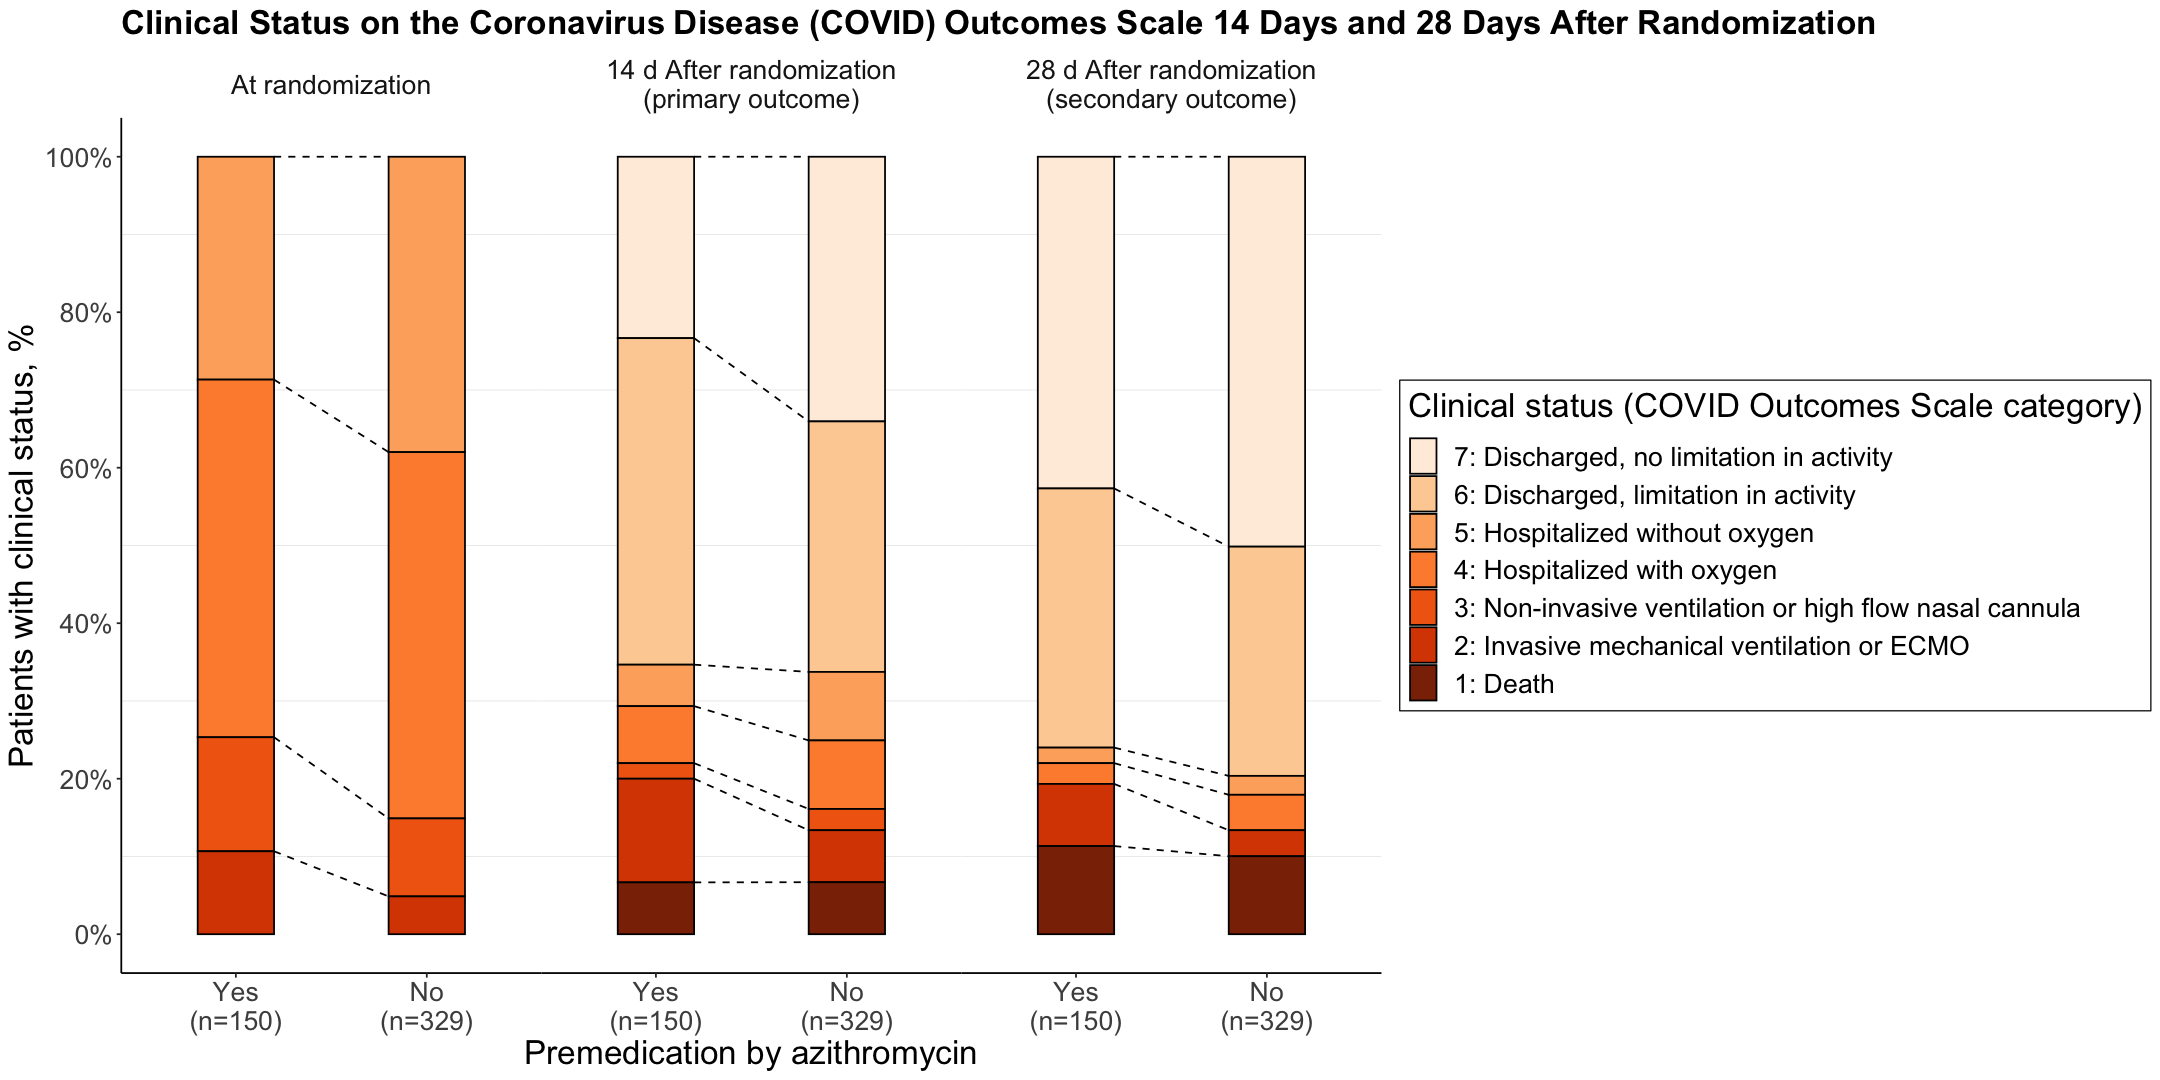

In [45]:
plot_count_COOS <- table_outcomes_count %>%
  ggplot() +
  geom_bar(aes(x = prmed_azithro, fill = COOS), 
           width = 0.4, position="fill", colour = "black") +
  scale_y_continuous(labels = scales::percent,
                     n.breaks = 6,
                     limits = c(0, 1)) +
  facet_grid( ~ date) +
  scale_fill_brewer(palette = "Oranges") +
  orchid_gg_theme(plot.title = element_markdown()) +
  labs(title="Clinical Status on the Coronavirus Disease (COVID) Outcomes Scale 14 Days and 28 Days After Randomization",
       fill = "Clinical status (COVID Outcomes Scale category)"
       ) +
  xlab("Premedication by azithromycin") +
  ylab("Patients with clinical status, %")

plot_data <- ggplot_build(plot_count_COOS)$data
line_data <- plot_data[[1]] %>%
    mutate(x_line = if_else(x == 1, xmax, xmin), 
           date = as.factor(if_else(PANEL == 1, 
                                    "At randomization",
                                    ifelse(PANEL == 2,
                                           "14 d After randomization\n(primary outcome)",
                                           "28 d After randomization\n(secondary outcome)"
                                           )
                            ))
          )
         
plot_count_COOS <- plot_count_COOS + 
    geom_line(data = line_data,
              aes(x = x_line, y = ymax, group = fill), 
              linetype = "dashed"
              )
print(plot_count_COOS)

This plot represents the patients' clinical status according at day 0, 14, and 28 from randomization. It shows that,  overall, patients who received premedication with azithromycin had more severe baseline clinical status. This translated into more severe outcomes at the different time points (day 14 and 28 from randomization). 

## Premedications and labs trajectories

In [ ]:
labs_names <- list(
    labs_wbch = "Highest white blood cell count (/mm3)", 
    labs_wbcl = "Lowest white blood cell count (/mm3)", 
    labs_hemol = "Lowest hemoglobin (g/dl)", 
    labs_plateletl = "Lowest platelet count (/mm3; in thousands)", 
    labs_sodiumh = "Highest sodium (mEq/L)", 
    labs_sodiuml = "Lowest sodium (mEq/L)", 
    labs_potassiumh = "Highest potassium (mEq/L)", 
    labs_potassiuml = "Lowest potassium (mEq/L)", 
    labs_chlorideh = "Highest chloride (mEq/L)", 
    labs_bicarbonateh = "Highest bicarbonate (mEq/L)", 
    labs_bicarbonatel = "Lowest bicarbonate (mEq/L)", 
    labs_bunh = "Highest BUN - Blood Urea Nitrogen (mg/dL)", 
    labs_creath = "Highest creatinine (mg/dL)", 
    labs_troph = "Highest troponin (mg/dL)", 
    labs_asth = "Highest AST - Aspartate aminotransferase (units per liter)", 
    labs_alth = "Highest ALT - Alanine aminotransferase (units per liter)", 
    labs_alph = "Highest ALP - Alkaline Phosphatase (IU/L)", 
    labs_totbilih = "Highest total bilirubin (mg/dL)", 
    labs_albuminl = "Lowest albumin (g/dL)", 
    labs_ptth = "Highest PTT - Partial Thromboplastin Time (seconds)", 
    labs_inrh = "Highest INR - International Normalized R"
)

In [ ]:
list_names = list()
for (labs in names(labs_names)) {
    list_names[[labs]] <- grep(labs, names(orchid_data), value = TRUE)
}
orchid_labs_names <- do.call(c, list_names) %>% unname()

In [ ]:
labs_long <- orchid_data[c("Patient ID", "rand_trt", "prmed_azithro", orchid_labs_names)] %>%
    pivot_longer(cols = all_of(orchid_labs_names), 
                 names_sep = "_(?=[0-9]$)", 
                 names_to = c("labs", "day"),
                 values_to = "values") %>%
    mutate(day = as.numeric(as.character(day)))

In [ ]:
summarized_labs <- labs_long %>% 
    group_by(rand_trt, prmed_azithro, labs, day) %>%
    summarise(mean = mean(values, na.rm = TRUE), 
              count = n(), 
              sd = sd(values, na.rm = TRUE)) %>%
   ungroup()

In [ ]:
summarized_labs <- labs_long %>% 
    group_by(rand_trt, prmed_azithro, labs, day) %>%
    summarise(mean = mean(values, na.rm = TRUE), 
              count = n(), 
              sd = sd(values, na.rm = TRUE)) %>%
   ungroup()

In [ ]:
labs_long %>%
group_by(prmed_azithro, labs, day) %>%
summarise(median = median(values, na.rm = TRUE),
          mean = mean(values, na.rm = TRUE),
          sd = sd(values, na.rm = TRUE), 
          n_obs = n()) %>% 
mutate(labs = recode(labs, !!!labs_names), 
       prmed_azithro = relevel(prmed_azithro, ref = "Yes")) %>% {
ggplot(., aes(x = day, 
           y = mean, 
           color = prmed_azithro, 
           shape = prmed_azithro)) +
geom_point(aes(size=n_obs)) +
geom_line() + 
# geom_errorbar(aes(ymin = pmax(0, mean - sd), ymax = mean + sd), width = 0.2) +
scale_size_binned() +
scale_color_brewer(palette = "Set1") +
facet_wrap("labs", scale = "free_y", labeller = label_wrap_gen(width=40)) + 
orchid_gg_theme() +
    theme(strip.text.x = element_text(size=11)) +
labs(title = "Labs trajectory from Day 1 to 5, depending on premedication", 
     subtitle = "Premedication by azythromycin", 
     x = "Days from inclusion", 
     y = "Mean concentration", 
     colour = "Azithromycin",
     shape = "Azithromycin",
     size = "Observation count")
}


Interpretation of these graphs: 

- Most significant differences are for the average level of troponin: patients that has been prescribed Azithromycin have average lower levels of troponin

In [ ]:
labs_long[labs_long$labs == "labs_asth", ] %>%
mutate(prmed_azithro = relevel(prmed_azithro, ref = "Yes")) %>%
   ggplot(aes(x=day, y=values, colour=prmed_azithro)) +
   geom_jitter(size=4) +
   scale_colour_brewer(palette = "Set1") +
   orchid_gg_theme() +
labs(title = paste0(labs_names[["labs_asth"]], " concentation"), 
     subtitle = "Premedication by azythromycin", 
     x = "Days from inclusion", 
     y = labs_names[["labs_troph"]], 
     colour = "Azithromycin")
   

In [ ]:
labs_long[labs_long$labs == "labs_alth", ] %>%
mutate(prmed_azithro = relevel(prmed_azithro, ref = "Yes")) %>%
   ggplot(aes(x=day, y=values, colour=prmed_azithro)) +
   geom_jitter(size=4) +
   scale_colour_brewer(palette = "Set1") +
   orchid_gg_theme() +
labs(title = paste0(labs_names[["labs_alth"]], " concentation"), 
     subtitle = "Premedication by azythromycin", 
     x = "Days from inclusion", 
     y = labs_names[["labs_troph"]], 
     colour = "Azithromycin")
   

In [ ]:
labs_long[labs_long$labs == "labs_alph", ] %>%
mutate(prmed_azithro = relevel(prmed_azithro, ref = "Yes")) %>%
   ggplot(aes(x=day, y=values, colour=prmed_azithro)) +
   geom_jitter(size=4) +
   scale_colour_brewer(palette = "Set1") +
   orchid_gg_theme() +
labs(title = paste0(labs_names[["labs_alph"]], " concentation"), 
     subtitle = "Premedication by azythromycin", 
     x = "Days from inclusion", 
     y = labs_names[["labs_troph"]], 
     colour = "Azithromycin")
   

In [ ]:
labs_long[labs_long$labs == "labs_troph", ] %>%
mutate(prmed_azithro = relevel(prmed_azithro, ref = "Yes")) %>%
   ggplot(aes(x=day, y=values, colour=prmed_azithro)) +
   geom_jitter(size=4) +
   scale_colour_brewer(palette = "Set1") +
   orchid_gg_theme() +
labs(title = paste0(labs_names[["labs_troph"]], " concentation"), 
     subtitle = "Premedication by azythromycin", 
     x = "Days from inclusion", 
     y = labs_names[["labs_troph"]], 
     colour = "Azithromycin")
   

In [ ]:
labs_long[grepl("labs_totbilih", labs_long$labs), ] %>%
mutate(prmed_azithro = relevel(prmed_azithro, ref = "Yes")) %>%
   ggplot(aes(x=day, y=values, colour=prmed_azithro)) +
   geom_jitter(size=4) +
   scale_colour_brewer(palette = "Set1") +
   orchid_gg_theme() +
labs(title = paste0(labs_names[["labs_totbilih"]], " concentation"), 
     subtitle = "Premedication by azythromycin", 
     x = "Days from inclusion", 
     y = labs_names[["labs_totbilih"]], 
     colour = "Azithromycin")
   